# Py - RTTOV

[PDF Python Interface Guide - NWP/SAF](https://nwp-saf.eumetsat.int/site/download/documentation/rtm/docs_rttov12/rttov-wrapper.pdf)



In [1]:
# System information
import pyrttov
import numpy as np
import os, sys, glob
import xarray
print(sys.executable)
print(sys.version_info)
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/bin/python
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [2]:
def ef(p, t=None, over_water=True, over_ice=False, **kwargs):
    """
    from
    Sugidachi, T. and Fujiwara, M.: Correction of the Stepwise Change Observed at 0C in
    Meisei RS2-91, RS-01G, and RS-06G Radiosonde Relative Humidity Profiles,
    Journal of the Meteorological Society of Japan. Ser. II, 91(3), 323-336,
    doi:10.2151/jmsj.2013-306, 2013.

    Args:
        t: air temperature K
        p: air pressure Pa

    Returns:
        f : enhancement factor for saturation water vapor pressure
            depending on air temperature and air pressure
    """
    # Vaisala / Buck 1981  / WMO 2008
    # 1.0016 + 3.15e-6*p - 0.074 / p  # kPa
    if over_water:
        return 1.0007 + (3.46e-6 * p / 100)
    if over_ice:
        return 1.0003 + (4.18e-6 * p / 100)
    if t is not None:
        return np.where(t < 273.16,
                        1.0003 + (4.18e-6 * p / 100),
                        1.0007 + (3.46e-6 * p / 100))

In [3]:
def HylandWexler(temp, over_water=True, over_ice=False, **kwargs):
    """Hyland and Wexler (1983), also in Wexler and Hyland (1983): Stated ranges 173.16 ?
    T < 273.16 for ice and 273.16 > 473.15 for liquid.

    Used by Vaisala

    ln( ew ) = -5800.2206/t + 1.3914993
               - 0.48640239 * 10**(-1)*t
               + 0.41764768 * 10**(-4)*t**2
               - 0.14452093 * 10**(-7)*t**3
               + 6.5459673*math.log(t)

    ln( ei ) = -5674.5359/t + 6.3925247
               - 0.96778430 * 10**(-2)*t
               + 0.62215701 * 10**(-6)*t**2
               + 0.20747825 * 10**(-8)*t**3
               - 0.94840240 * 10**(-12)*t**4
               + 4.1635019*math.log(t)

    Args:
        temp: air temperature in K
        liquid_only: use only water vapor over liquid water
        ice_only: use only water vapor over ice
        kwargs: dummy

    Returns:
         es : saturation water vapor pressure in Pa
    """

    def liquid(t):
        return np.exp(
            -5800.2206 / t + 1.3914993
            - 0.48640239e-1 * t
            + 0.41764768e-4 * t * t
            - 0.14452093e-7 * t * t * t
            + 6.5459673 * np.log(t)
        )

    def ice(t):
        return np.exp(
            -5674.5359 / t + 6.3925247
            - 0.96778430e-2 * t
            + 0.62215701e-6 * t * t
            + 0.20747825e-8 * t * t * t
            - 0.94840240e-12 * t * t * t * t
            + 4.1635019 * np.log(t)
        )

    if over_water:
        return liquid(temp)
    elif over_ice:
        return ice(temp)
    else:
        return np.where(temp < 273.16, ice(temp), liquid(temp))

In [4]:
def svp(t, method='HylandWexler', p=None, **kwargs):
    """
    Saturation water vapor pressure from Temperature
    The equations by Hyland and Wexler [4], the nearly identical equation by Wexler (1976, see reference below) and
    the equation by Sonntag [7] are the most commonly used equations among Radiosonde manufacturers
    and should be used in upper air applications to avoid inconsistencies.

    Known Saturation water Vapor Formulations:

    Bolton 1980
    Goff 1957, 1965        (180    - 273.15 / 273.15 - 373.15) 1957> WMO
    Goff and Gratch 1946   (184    - 273.15 / 273.15 - 373.15)
    Hyland and Wexler 1983 (173.16 - 273.15 / 273.15 - 473.15) Vaisala
    IAPWS 1995             (173.15 - 273.15 / 273.15 - 647   ) Wagner and Pruss + Wagner 1994
    Murphy and Koop 2005   (110    - 273.15 / 132      332   ) Ice formulation as well
    Sonntag 1990           (173.15 - 273.15 / 273.15 - 373.15)
    Sonntag 1994           (173.15 - 273.15 / 273.15 - 373.15)
    Wagner 1994            (190    - 273.15                  )
    Wagner and Pruss 1993  (190    - 273.15 / 273.15 - 647   )
    Wexler 1976            (                  273.15 - 373.15)
    Wright 1997

    Args:
        t: air temperature
        method: string or function
        p: pressure
        **kwargs: additional keywords passed to function

    Returns:
        es : saturation water vapor pressure in Pa
    """
    try:
        if callable(method):
            vpfunc = method
        else:
            vpfunc = eval(method)

        if p is not None:
            f = ef(p, **kwargs)
        else:
            f = 1.
        return vpfunc(t, **kwargs) * f
    except:
        import sys
        print("Functions: ", ", ".join([i for i in dir(sys.modules[__name__]) if i[0].upper() == i[0]]))

In [5]:
def vap2sh(e, p):
    """ Convert water vapor pressure to specific humidity
    Parameters
    ----------
    e      Water vapor [Pa]
    p      total air pressure [Pa]

    Returns
    -------
    specific humidity (1 = kg/kg)
    """
    rd = 287.05
    rv = 461.50
    c = rd/rv  # Rd/Rv = 0.6219934994582882
    pa = p - e  # dry air pressure
    return (e * c) / (e * c + pa)

In [6]:
def dp_sh(dp, press):
        vpdata = svp(dp, p=press)
        q = vap2sh(vpdata, press)
        return q
       

In [7]:
def rttov_calc(ascent, era, date):
    rttov_installdir = '/rttov/'

    # ------------------------------------------------------------------------
    # Set up the profile data
    # ------------------------------------------------------------------------

    # Declare an instance of Profiles
    nlevels = len(ascent.index)
    nprofiles = 1
    myProfiles = pyrttov.Profiles(nprofiles, nlevels)

    # Associate the profiles and other data from example_data.h with myProfiles
    # Note that the simplecloud, clwscheme, icecloud and zeeman data are not mandatory and
    # are omitted here

    def expand2nprofiles(n, nprof):
        # Transform 1D array to a [nprof, nlevels] array
        outp = np.empty((nprof, len(n)), dtype=n.dtype)
        for i in range(nprof):
            outp[i, :] = n[:]
        return outp

    myProfiles.GasUnits = 1
    myProfiles.P = expand2nprofiles(np.array(ascent.index)/100., nprofiles) 
#     print(myProfiles.P)
    myProfiles.T = expand2nprofiles(np.array(ascent.ta), nprofiles) 
#     print(myProfiles.T)
    myProfiles.Q = expand2nprofiles(np.array(ascent.hus), nprofiles) 
#     print(myProfiles.Q)
    
    
    
    myProfiles.Angles = [[0, 0, 45, 180]]
    # satzen, satazi, sunzen, sunazi
    myProfiles.S2m = [[float(era.sp)/100., float(era.t2m), dp_sh(float(era.d2m), float(era.sp)), float(era.u10), float(era.v10), 100000]]
#     print(myProfiles.S2m)
    # s2m%p, s2m%t, s2m%q, s2m%u, s2m%v, s2m%wfetch
    myProfiles.Skin = [[float(era.skt), 0, 0, 0, 3.0, 5., 15, 0.1, 0.3, 0]] #float(era.snowc)/100., 3.0, 5., 15, 0.1, 0.3, 0]]
    # (skin%t, skin%salinity, skin%foam_fraction, skin%snow_fraction skin%fastem(1:5)) --> fastem default =  3.0, 5., 15, 0.1, 0.3, 0
    myProfiles.SurfType = [[0, 0]]
    # skin%surftype
    myProfiles.SurfGeom = [[df.lat.iloc[0], df.lon.iloc[0], 0.]]
    # (latitude, longitude, elevation)
    myProfiles.DateTimes = [[date.year, date.month, date.day, 0, 0, 0]]
    # (year, month, day, hour, minute, second)
    
    
    # ------------------------------------------------------------------------
    # Set up Rttov instances for each instrument
    # ------------------------------------------------------------------------

    # Create three Rttov objects for three instruments
    msuRttov = pyrttov.Rttov()

    nchan_msu = 3
    chan_list_msu = [2, 3, 4]

    # Set the options for each Rttov instance:
    # - the path to the coefficient file must always be specified
    # - turn RTTOV interpolation on (because input pressure levels differ from
    #   coefficient file levels)
    # - set the verbose_wrapper flag to true so the wrapper provides more
    #   information
    # - enable solar simulations for SEVIRI
    # - enable CO2 simulations for HIRS (the CO2 profiles are ignored for
    #   the SEVIRI and MHS simulations)
    # - enable the store_trans wrapper option for MHS to provide access to
    #   RTTOV transmission structure
#     print("/rttov/rtcoef_rttov12/rttov7pred54L/rtcoef_noaa_14_msu.dat")
#     msuRttov.FileCoef = '{}/{}'.format(rttov_installdir,
#                                        "rtcoef_rttov12/rttov7pred54L/rtcoef_noaa_14_msu.dat")
    msuRttov.FileCoef = "/rttov/rtcoef_rttov12/rttov7pred54L/rtcoef_noaa_14_msu.dat"
    msuRttov.Options.AddInterp = True
#     msuRttov.Options.AddSolar = True
#     msuRttov.Options.CO2Data = False
    msuRttov.Options.VerboseWrapper = True


    # Load the instruments: for HIRS and MHS do not supply a channel list and
    # so read all channels
#     try:
    msuRttov.loadInst(channels=chan_list_msu)
#     msuRttov.loadInst()
#     except pyrttov.RttovError as e:
#         sys.stderr.write("Error loading instrument(s): {!s}".format(e))
#         sys.exit(1)

    # Associate the profiles with each Rttov instance
    msuRttov.Profiles = myProfiles

    # ------------------------------------------------------------------------
    # Load the emissivity and BRDF atlases
    # ------------------------------------------------------------------------

    # Load the emissivity and BRDF atlases:
    # - load data for the month in the profile data
    # - load the IR emissivity atlas data for multiple instruments so it can be used for SEVIRI and HIRS
    # - SEVIRI is the only VIS/NIR instrument we can use the single-instrument initialisation for the BRDF atlas

#     irAtlas = pyrttov.Atlas()
#     irAtlas.AtlasPath = '{}/{}'.format(rttov_installdir, "emis_data")
#     irAtlas.loadIrEmisAtlas(ex.datetimes[1][0], ang_corr=True) # Include angular correction, but do not initialise for single-instrument

#     brdfAtlas = pyrttov.Atlas()
#     brdfAtlas.AtlasPath = '{}/{}'.format(rttov_installdir, "brdf_data")
#     brdfAtlas.loadBrdfAtlas(ex.datetimes[1][0], msuRttov) # Supply Rttov object to enable single-instrument initialisation
#     brdfAtlas.IncSea = False                                 # Do not use BRDF atlas for sea surface types

    # TELSEM2 atlas does not require an Rttov object to initialise
    mwAtlas = pyrttov.Atlas()
    mwAtlas.AtlasPath = '{}/{}'.format(rttov_installdir, "emis_data")
    mwAtlas.loadMwEmisAtlas(date.month)

    # Set up the surface emissivity/reflectance arrays and associate with the Rttov objects
    surfemisrefl_msu = np.zeros((2,nprofiles,nchan_msu), dtype=np.float64)

#     seviriRttov.SurfEmisRefl = surfemisrefl_msu

    # ------------------------------------------------------------------------
    # Call RTTOV
    # ------------------------------------------------------------------------

    # Surface emissivity/reflectance arrays must be initialised *before every call to RTTOV*
    # Negative values will cause RTTOV to supply emissivity/BRDF values (i.e. equivalent to
    # calcemis/calcrefl TRUE - see RTTOV user guide)

    surfemisrefl_msu[:,:,:] = -1.

    # Call emissivity and BRDF atlases
    try:
        # Do not supply a channel list for SEVIRI: this returns emissivity/BRDF values for all
        # *loaded* channels which is what is required
#         surfemisrefl_seviri[0,:,:] = irAtlas.getEmisBrdf(seviriRttov)
#         surfemisrefl_seviri[1,:,:] = brdfAtlas.getEmisBrdf(seviriRttov)
#         surfemisrefl_hirs[0,:,:] = irAtlas.getEmisBrdf(hirsRttov)
#         surfemisrefl_mhs[0,:,:] = mwAtlas.getEmisBrdf(mhsRttov)

        surfemisrefl_msu[0,:,:] = mwAtlas.getEmisBrdf(msuRttov)


    except pyrttov.RttovError as e:
        # If there was an error the emissivities/BRDFs will not have been modified so it
        # is OK to continue and call RTTOV with calcemis/calcrefl set to TRUE everywhere
        sys.stderr.write("Error calling atlas: {!s}".format(e))

    # Call the RTTOV direct model for each instrument:
    # no arguments are supplied to runDirect so all loaded channels are
    # simulated
    try:
        msuRttov.runDirect()
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)

    # ------------------------------------------------------------------------
    # Print out some of the output
    # ------------------------------------------------------------------------

    print
    print("SELECTED OUTPUT")
    print

    print("MSU visible channel reflectances, channels 2-4")
    for p in range(nprofiles):
        print("Profile {:d}:".format(p))
        for c in range(3):
            print("  Ch #{:02d} refl={:f}".format(chan_list_msu[c],
                                                  msuRttov.BtRefl[p, c]))
        print
    return chan_list_msu, msuRttov.BtRefl


# PyRTTOV Testing

In [8]:
# import cdsapi
# c = cdsapi.Client()
# for yr in range(1981,2022,1):
#     print(yr)
#     r = c.retrieve(
#         'reanalysis-era5-land-monthly-means',
#         {
#             'format': 'netcdf',
#             'variable': [
#                 '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
#                 '2m_temperature', 'skin_temperature', 'snow_cover',
#                 'surface_pressure',
#             ],
#             'product_type': 'monthly_averaged_reanalysis',
#             'year': yr,
#             'month': [
#                 '01', '02', '03',
#                 '04', '05', '06',
#                 '07', '08', '09',
#                 '10', '11', '12',
#             ],
#             'time': '00:00',
#         },
#         'download.nc')
#     r.download(target='era_land'+ str(yr)+'.nc')
#     print('done')

In [4]:
%pip install cdsapi

  Created wheel for cdsapi: filename=cdsapi-0.5.1-py2.py3-none-any.whl size=11687 sha256=9ef89e9881094591a18e88a81c3ac00da46d8fadd3877c6e39dbd002c5fd95c8
  Stored in directory: /home/srvx11/lehre/users/a1400070/.cache/pip/wheels/b3/da/d4/76acb1b249ba411fb70ca7baf0d6ab7d6177e1f0d14f1383c1
Successfully built cdsapi
ERROR: Could not install packages due to an EnvironmentError: [Errno 30] Read-only file system: '/opt/conda/lib/python3.7/site-packages/cdsapi'

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# statid = '10393'
# try:
#     os.mkdir('./rttov_cuon_input/'+statid)
# except:
#     pass
# for yr in range(1981,2022,1):
#     for mon in range(int(str(yr)+'01'), int(str(yr)+'13'), 1):
#         c = cdsapi.Client()
#         r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
#                        {
#                            'variable': ["temperature","specific_humidity"],
#                            'date': [str(mon)+'01',str(mon)+'31'],
#                            'statid': [statid],
#                        })
#         r.download(target='rt.zip')
#         assert os.stat('rt.zip').st_size == r.content_length, "Downloaded file is incomplete"
#         z = zipfile.ZipFile('rt.zip')
#         os.mkdir('./rttov_cuon_input/'+statid+'/'+str(mon))
#         z.extractall(path='./rttov_cuon_input/'+statid+'/'+str(mon)+'/')
#         z.close()

In [ ]:
statid = '11035'
chan_list = []
refl = []
dates = []
for yr in range(1979,2022,1):
    for mon in range(int(str(yr)+'01'), int(str(yr)+'13'), 1):
        try:
            # add file download once on srvx2
            dfsh = xarray.open_dataset(glob.glob('./rttov_cuon_input/'+statid+'/'+str(mon)+'/dest*spec*')[0]).hus.to_dataframe()
            dfta = xarray.open_dataset(glob.glob('./rttov_cuon_input/'+statid+'/'+str(mon)+'/dest*temp*')[0]).ta.to_dataframe()
            df = dfta.merge(dfsh, how='inner', on=['plev', 'time', 'lat', 'lon'])
            mon_mean = df.groupby(['plev']).aggregate({"ta":np.mean, "hus":np.mean})

            era = xarray.open_dataset('./era/era_'+str(yr)+'.nc')
            era_input = era.sel(time = str(yr)+'-'+str(mon)[-2:]+'-01T00:00:00.000000000', latitude = dfta.lat.iloc[0], longitude = dfta.lon.iloc[0], method='nearest')
            date = pd.to_datetime(float(era_input.time))

            a, b = rttov_calc(mon_mean, era_input, date)
            chan_list.append(a)
            refl.append(b)
            dates.append(mon)
        except:
            chan_list.append(np.nan)
            refl.append(np.array([[np.nan,np.nan,np.nan]]))
            dates.append(mon)
        

Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.774280
  Ch #03 refl=223.894431
  Ch #04 refl=218.691689


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=265.700006
  Ch #03 refl=265.700006
  Ch #04 refl=265.700007


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.317227
  Ch #03 refl=226.759344
  Ch #04 refl=221.290140


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.071516
  Ch #03 refl=230.106298
  Ch #04 refl=219.022091


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.321943
  Ch #03 refl=230.119233
  Ch #04 refl=211.474782


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.810108
  Ch #03 refl=230.521544
  Ch #04 refl=218.943429


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.303817
  Ch #03 refl=229.200066
  Ch #04 refl=218.171996


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.039847
  Ch #03 refl=227.525240
  Ch #04 refl=216.816677


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.809054
  Ch #03 refl=225.184482
  Ch #04 refl=216.735634


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.154447
  Ch #03 refl=224.755210
  Ch #04 refl=217.607100


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.020234
  Ch #03 refl=223.495225
  Ch #04 refl=214.863347


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.225541
  Ch #03 refl=225.886886
  Ch #04 refl=218.844339


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=nan
  Ch #03 refl=nan
  Ch #04 refl=nan


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.110909
  Ch #03 refl=226.486872
  Ch #04 refl=218.917304


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.912434
  Ch #03 refl=228.222027
  Ch #04 refl=220.388954


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.868133
  Ch #03 refl=230.319509
  Ch #04 refl=221.065947


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=280.200012
  Ch #03 refl=280.200012
  Ch #04 refl=280.200012


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.458984
  Ch #03 refl=230.321242
  Ch #04 refl=217.682426


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.646275
  Ch #03 refl=228.476786
  Ch #04 refl=214.854329


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.747570
  Ch #03 refl=227.585877
  Ch #04 refl=216.796851


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.129340
  Ch #03 refl=225.594340
  Ch #04 refl=215.185550


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.716599
  Ch #03 refl=225.796286
  Ch #04 refl=217.607024


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.619784
  Ch #03 refl=225.141837
  Ch #04 refl=216.021701


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.933591
  Ch #03 refl=223.994740
  Ch #04 refl=218.199573


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.694020
  Ch #03 refl=249.694299
  Ch #04 refl=249.694842


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.292377
  Ch #03 refl=226.368916
  Ch #04 refl=218.476072


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.164185
  Ch #03 refl=228.612108
  Ch #04 refl=219.643123
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.179557
  Ch #03 refl=229.112153
  Ch #04 refl=218.814958


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.472038
  Ch #03 refl=230.918607
  Ch #04 refl=217.440710


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.575049
  Ch #03 refl=231.079504
  Ch #04 refl=220.157242


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.763904
  Ch #03 refl=229.296887
  Ch #04 refl=216.347079


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.763755
  Ch #03 refl=227.191183
  Ch #04 refl=215.735530


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.350294
  Ch #03 refl=224.763691
  Ch #04 refl=214.654301


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.320635
  Ch #03 refl=224.979724
  Ch #04 refl=216.019953
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.123262
  Ch #03 refl=225.567739
  Ch #04 refl=218.637710


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.764446
  Ch #03 refl=224.047350
  Ch #04 refl=216.057159


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.454575
  Ch #03 refl=225.740885
  Ch #04 refl=217.846352


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.184524
  Ch #03 refl=228.300973
  Ch #04 refl=219.440875


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.369324
  Ch #03 refl=229.711491
  Ch #04 refl=220.319928


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.262316
  Ch #03 refl=231.649666
  Ch #04 refl=221.664864


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=238.749797
  Ch #03 refl=238.780251
  Ch #04 refl=239.070146


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.456368
  Ch #03 refl=229.485230
  Ch #04 refl=219.782554


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.237755
  Ch #03 refl=227.351358
  Ch #04 refl=215.234013


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.200144
  Ch #03 refl=225.320802
  Ch #04 refl=214.629598
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.165050
  Ch #03 refl=225.621195
  Ch #04 refl=218.292212


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=239.813909
  Ch #03 refl=223.298834
  Ch #04 refl=216.204080


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.570850
  Ch #03 refl=224.395955
  Ch #04 refl=216.962194


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.832692
  Ch #03 refl=225.284683
  Ch #04 refl=217.288167


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.769068
  Ch #03 refl=227.549777
  Ch #04 refl=220.133018
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=214.300003
  Ch #03 refl=214.300003
  Ch #04 refl=214.300003


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.310087
  Ch #03 refl=230.603155
  Ch #04 refl=222.166080
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.919085
  Ch #03 refl=229.621377
  Ch #04 refl=216.357603


Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.040500
  Ch #03 refl=230.228016
  Ch #04 refl=216.803321
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.425548
  Ch #03 refl=229.027149
  Ch #04 refl=217.558446


Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.336116
  Ch #03 refl=226.645478
  Ch #04 refl=216.221940


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.111995
  Ch #03 refl=224.858651
  Ch #04 refl=215.169103


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.871201
  Ch #03 refl=225.470430
  Ch #04 refl=216.206775


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.766465
  Ch #03 refl=224.172474
  Ch #04 refl=216.687404


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.284594
  Ch #03 refl=224.241376
  Ch #04 refl=219.308657


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.951656
  Ch #03 refl=227.548738
  Ch #04 refl=225.978579


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.324301
  Ch #03 refl=227.245289
  Ch #04 refl=220.823303


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.168275
  Ch #03 refl=227.295392
  Ch #04 refl=217.227637


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.312774
  Ch #03 refl=229.987291
  Ch #04 refl=221.159910
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.359095
  Ch #03 refl=230.237374
  Ch #04 refl=218.256503


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.264884
  Ch #03 refl=230.466346
  Ch #04 refl=218.561573


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.235691
  Ch #03 refl=228.773396
  Ch #04 refl=220.954810


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.092120
  Ch #03 refl=227.039043
  Ch #04 refl=215.733520


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.979251
  Ch #03 refl=224.985621
  Ch #04 refl=214.074283


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.061371
  Ch #03 refl=223.727614
  Ch #04 refl=214.959961


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.646333
  Ch #03 refl=222.733108
  Ch #04 refl=213.814657


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.419657
  Ch #03 refl=224.387054
  Ch #04 refl=216.714728
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.357036
  Ch #03 refl=224.858713
  Ch #04 refl=219.359362


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.662211
  Ch #03 refl=225.668357
  Ch #04 refl=217.640804


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.171286
  Ch #03 refl=228.767686
  Ch #04 refl=221.243845


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=262.953580
  Ch #03 refl=262.957700
  Ch #04 refl=262.964213


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.668567
  Ch #03 refl=231.416767
  Ch #04 refl=220.623091


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.499470
  Ch #03 refl=252.499494
  Ch #04 refl=252.499536


Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.538779
  Ch #03 refl=228.481401
  Ch #04 refl=216.306463


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=236.668599
  Ch #03 refl=236.855515
  Ch #04 refl=237.415359


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.918119
  Ch #03 refl=224.547746
  Ch #04 refl=214.122873


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.125021
  Ch #03 refl=226.390254
  Ch #04 refl=220.634138


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.160284
  Ch #03 refl=225.057216
  Ch #04 refl=217.704835


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.330115
  Ch #03 refl=226.143372
  Ch #04 refl=220.957681


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.705068
  Ch #03 refl=226.539666
  Ch #04 refl=218.216693


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.496860
  Ch #03 refl=228.214893
  Ch #04 refl=218.330587


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.935572
  Ch #03 refl=229.927571
  Ch #04 refl=218.956881


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.010509
  Ch #03 refl=231.357567
  Ch #04 refl=218.151596


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.785908
  Ch #03 refl=230.697054
  Ch #04 refl=216.240114


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.897621
  Ch #03 refl=251.897655
  Ch #04 refl=251.897749


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.060422
  Ch #03 refl=227.711715
  Ch #04 refl=216.667356


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.429116
  Ch #03 refl=225.345102
  Ch #04 refl=214.963114


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.784480
  Ch #03 refl=226.153153
  Ch #04 refl=218.531104


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.676891
  Ch #03 refl=226.298802
  Ch #04 refl=218.266284


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.503887
  Ch #03 refl=227.312344
  Ch #04 refl=221.022706


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.410679
  Ch #03 refl=226.366786
  Ch #04 refl=217.605466


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.794592
  Ch #03 refl=227.529212
  Ch #04 refl=219.577268


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.233646
  Ch #03 refl=227.291277
  Ch #04 refl=217.950736


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.597859
  Ch #03 refl=226.826362
  Ch #04 refl=221.153935


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.076111
  Ch #03 refl=231.241515
  Ch #04 refl=220.317056


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.337695
  Ch #03 refl=231.397240
  Ch #04 refl=220.400844


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.663429
  Ch #03 refl=229.332406
  Ch #04 refl=216.058997


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.981144
  Ch #03 refl=227.964137
  Ch #04 refl=217.957875


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.468901
  Ch #03 refl=225.495000
  Ch #04 refl=215.738804


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.070695
  Ch #03 refl=226.791324
  Ch #04 refl=217.986079


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.652209
  Ch #03 refl=243.654547
  Ch #04 refl=243.659160


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.502438
  Ch #03 refl=226.533101
  Ch #04 refl=216.984176


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.208808
  Ch #03 refl=227.061691
  Ch #04 refl=217.696918


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.666474
  Ch #03 refl=227.649734
  Ch #04 refl=219.948217


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.019031
  Ch #03 refl=228.041303
  Ch #04 refl=219.071576


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.718890
  Ch #03 refl=230.404221
  Ch #04 refl=220.041990


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.371283
  Ch #03 refl=231.543839
  Ch #04 refl=219.778731


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.702259
  Ch #03 refl=231.207242
  Ch #04 refl=220.796444


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.701392
  Ch #03 refl=228.932202
  Ch #04 refl=218.454553


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.885779
  Ch #03 refl=227.991611
  Ch #04 refl=215.089355


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.341150
  Ch #03 refl=226.570740
  Ch #04 refl=218.712631


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.354434
  Ch #03 refl=225.168289
  Ch #04 refl=217.747676


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=nan
  Ch #03 refl=nan
  Ch #04 refl=nan


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.386633
  Ch #03 refl=225.416718
  Ch #04 refl=220.295649


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.980822
  Ch #03 refl=226.137793
  Ch #04 refl=216.160677


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.280746
  Ch #03 refl=226.452646
  Ch #04 refl=219.550559


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.905945
  Ch #03 refl=228.280006
  Ch #04 refl=220.684132


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.337310
  Ch #03 refl=230.164375
  Ch #04 refl=220.352302


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.423081
  Ch #03 refl=231.885748
  Ch #04 refl=219.982050


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.505523
  Ch #03 refl=230.846345
  Ch #04 refl=218.020792


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.068671
  Ch #03 refl=229.555923
  Ch #04 refl=217.588068
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.137984
  Ch #03 refl=228.392156
  Ch #04 refl=217.571193


Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.528547
  Ch #03 refl=226.047024
  Ch #04 refl=215.536433


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.462434
  Ch #03 refl=227.126888
  Ch #04 refl=220.966233


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.583446
  Ch #03 refl=224.312325
  Ch #04 refl=214.347454


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.549006
  Ch #03 refl=225.968109
  Ch #04 refl=217.959503


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.934215
  Ch #03 refl=225.896255
  Ch #04 refl=216.478286


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.505252
  Ch #03 refl=227.951208
  Ch #04 refl=220.534191


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.221694
  Ch #03 refl=227.925562
  Ch #04 refl=218.282180


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.897955
  Ch #03 refl=230.158423
  Ch #04 refl=219.787778


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.210849
  Ch #03 refl=231.411114
  Ch #04 refl=221.598093


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=256.311774
  Ch #03 refl=230.766037
  Ch #04 refl=216.937069


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.372676
  Ch #03 refl=229.617753
  Ch #04 refl=218.199277


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.285829
  Ch #03 refl=227.310344
  Ch #04 refl=217.767521


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.770578
  Ch #03 refl=226.616920
  Ch #04 refl=217.630033


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.049202
  Ch #03 refl=225.809905
  Ch #04 refl=215.856942


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.584893
  Ch #03 refl=225.665086
  Ch #04 refl=217.072880


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.261008
  Ch #03 refl=225.470391
  Ch #04 refl=219.293285


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.356203
  Ch #03 refl=226.379378
  Ch #04 refl=219.063691


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.609599
  Ch #03 refl=225.717892
  Ch #04 refl=216.125900


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.865388
  Ch #03 refl=227.837016
  Ch #04 refl=217.224848


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.808430
  Ch #03 refl=230.535322
  Ch #04 refl=220.503144


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.815278
  Ch #03 refl=230.979262
  Ch #04 refl=218.347845


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.915825
  Ch #03 refl=229.950252
  Ch #04 refl=215.838166


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.684602
  Ch #03 refl=229.435316
  Ch #04 refl=219.564713


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.912561
  Ch #03 refl=227.471464
  Ch #04 refl=215.656140


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.057021
  Ch #03 refl=243.063811
  Ch #04 refl=243.084126


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.782433
  Ch #03 refl=226.726232
  Ch #04 refl=220.095592


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.294296
  Ch #03 refl=225.718023
  Ch #04 refl=216.425118


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=218.886807
  Ch #03 refl=218.941086
  Ch #04 refl=219.100673


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.376097
  Ch #03 refl=230.241504
  Ch #04 refl=218.839471


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.177405
  Ch #03 refl=231.110709
  Ch #04 refl=218.630567


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.356841
  Ch #03 refl=227.916830
  Ch #04 refl=216.123987


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.069940
  Ch #03 refl=226.397289
  Ch #04 refl=215.346876


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.189267
  Ch #03 refl=225.206168
  Ch #04 refl=215.407988


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.871146
  Ch #03 refl=225.789490
  Ch #04 refl=217.815496


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.098783
  Ch #03 refl=248.098808
  Ch #04 refl=248.098871


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.922415
  Ch #03 refl=225.578825
  Ch #04 refl=218.110368


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.719608
  Ch #03 refl=226.511851
  Ch #04 refl=217.055542


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.909354
  Ch #03 refl=228.102415
  Ch #04 refl=219.765220


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.307187
  Ch #03 refl=230.139111
  Ch #04 refl=219.062807


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.885806
  Ch #03 refl=230.919436
  Ch #04 refl=216.712598


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.586481
  Ch #03 refl=230.329870
  Ch #04 refl=218.478966


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.299575
  Ch #03 refl=230.036894
  Ch #04 refl=220.242055


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.843775
  Ch #03 refl=228.642546
  Ch #04 refl=216.960285


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.284623
  Ch #03 refl=225.828022
  Ch #04 refl=216.302948


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.507536
  Ch #03 refl=224.699648
  Ch #04 refl=217.532655


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.802773
  Ch #03 refl=225.176771
  Ch #04 refl=215.909042


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.707130
  Ch #03 refl=224.991757
  Ch #04 refl=218.263494


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.831736
  Ch #03 refl=224.795408
  Ch #04 refl=218.287352


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.404185
  Ch #03 refl=224.994439
  Ch #04 refl=215.704981


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.890200
  Ch #03 refl=229.283112
  Ch #04 refl=221.062533
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.889097
  Ch #03 refl=230.000954
  Ch #04 refl=219.987303


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.661163
  Ch #03 refl=231.089051
  Ch #04 refl=219.558784


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.712781
  Ch #03 refl=230.706886
  Ch #04 refl=218.501091


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.602914
  Ch #03 refl=228.144261
  Ch #04 refl=217.816293


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.321967
  Ch #03 refl=226.313362
  Ch #04 refl=213.954272


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.609006
  Ch #03 refl=223.282730
  Ch #04 refl=210.183867


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.529648
  Ch #03 refl=221.567405
  Ch #04 refl=208.392844


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.220068
  Ch #03 refl=222.127210
  Ch #04 refl=212.475942


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.156344
  Ch #03 refl=223.582732
  Ch #04 refl=215.437510


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.107760
  Ch #03 refl=224.581947
  Ch #04 refl=215.740767


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.311062
  Ch #03 refl=223.701292
  Ch #04 refl=214.874011


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.956547
  Ch #03 refl=227.653215
  Ch #04 refl=218.546742


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.882663
  Ch #03 refl=229.470366
  Ch #04 refl=218.055327


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.085719
  Ch #03 refl=229.957765
  Ch #04 refl=219.474152


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.600655
  Ch #03 refl=231.023090
  Ch #04 refl=219.849063


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.240772
  Ch #03 refl=228.328535
  Ch #04 refl=213.934775


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.031277
  Ch #03 refl=225.690448
  Ch #04 refl=212.818239


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.060975
  Ch #03 refl=224.318137
  Ch #04 refl=211.843839


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.634166
  Ch #03 refl=222.081301
  Ch #04 refl=209.344625


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.208526
  Ch #03 refl=221.955625
  Ch #04 refl=211.511140


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.162101
  Ch #03 refl=222.163389
  Ch #04 refl=209.060753


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.103584
  Ch #03 refl=223.113192
  Ch #04 refl=214.384510


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.316292
  Ch #03 refl=225.585090
  Ch #04 refl=217.328340


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.947035
  Ch #03 refl=227.990362
  Ch #04 refl=219.357258


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.325069
  Ch #03 refl=230.231109
  Ch #04 refl=218.753112


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.849814
  Ch #03 refl=231.883839
  Ch #04 refl=219.696973


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.563550
  Ch #03 refl=230.818605
  Ch #04 refl=218.490633


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.144356
  Ch #03 refl=229.663363
  Ch #04 refl=218.661418


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.254866
  Ch #03 refl=226.506341
  Ch #04 refl=214.145061


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.500173
  Ch #03 refl=222.959390
  Ch #04 refl=210.183758


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.073718
  Ch #03 refl=222.248725
  Ch #04 refl=209.755226


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.756210
  Ch #03 refl=222.828275
  Ch #04 refl=210.177345


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.284749
  Ch #03 refl=222.094919
  Ch #04 refl=212.436070


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.323056
  Ch #03 refl=223.435472
  Ch #04 refl=214.475777


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.727368
  Ch #03 refl=225.473917
  Ch #04 refl=216.571190


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.372466
  Ch #03 refl=227.205387
  Ch #04 refl=216.919373


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.069855
  Ch #03 refl=229.775833
  Ch #04 refl=218.620146


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.556566
  Ch #03 refl=231.074052
  Ch #04 refl=218.550034


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.070514
  Ch #03 refl=230.542521
  Ch #04 refl=218.634700


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.398709
  Ch #03 refl=228.644841
  Ch #04 refl=214.834494


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.358783
  Ch #03 refl=226.450760
  Ch #04 refl=213.734301


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.684791
  Ch #03 refl=223.895477
  Ch #04 refl=211.049545


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.313212
  Ch #03 refl=223.266151
  Ch #04 refl=210.486614


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.901907
  Ch #03 refl=222.289890
  Ch #04 refl=211.326784


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.603911
  Ch #03 refl=223.832405
  Ch #04 refl=214.001514


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.607069
  Ch #03 refl=222.317210
  Ch #04 refl=209.417498
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.157593
  Ch #03 refl=226.439556
  Ch #04 refl=218.516458


Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.813167
  Ch #03 refl=227.097065
  Ch #04 refl=217.436897


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.481957
  Ch #03 refl=229.833216
  Ch #04 refl=218.534685
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.035018
  Ch #03 refl=230.687034
  Ch #04 refl=219.202507


Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.757216
  Ch #03 refl=230.396641
  Ch #04 refl=217.055214


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.843091
  Ch #03 refl=228.396628
  Ch #04 refl=217.388137


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.411408
  Ch #03 refl=225.965499
  Ch #04 refl=212.682887


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.368303
  Ch #03 refl=222.980774
  Ch #04 refl=209.122250


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.380475
  Ch #03 refl=222.769451
  Ch #04 refl=210.535054


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.274738
  Ch #03 refl=222.581229
  Ch #04 refl=210.754288


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.754249
  Ch #03 refl=222.140107
  Ch #04 refl=211.180181


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.491155
  Ch #03 refl=224.543610
  Ch #04 refl=214.578572


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.454467
  Ch #03 refl=226.273742
  Ch #04 refl=218.500352


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.415926
  Ch #03 refl=227.337101
  Ch #04 refl=216.319170


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.744683
  Ch #03 refl=229.797304
  Ch #04 refl=220.236124


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.791827
  Ch #03 refl=231.568361
  Ch #04 refl=220.057420


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.559494
  Ch #03 refl=230.849506
  Ch #04 refl=218.177970


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.633279
  Ch #03 refl=229.350292
  Ch #04 refl=219.880361


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.231483
  Ch #03 refl=226.444186
  Ch #04 refl=212.558618


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.044517
  Ch #03 refl=223.638620
  Ch #04 refl=210.540635


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.041106
  Ch #03 refl=222.182303
  Ch #04 refl=210.207669


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.183002
  Ch #03 refl=221.757276
  Ch #04 refl=208.817198


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.954820
  Ch #03 refl=223.681994
  Ch #04 refl=211.490461


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.360401
  Ch #03 refl=224.606719
  Ch #04 refl=214.980249


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.470826
  Ch #03 refl=226.253682
  Ch #04 refl=218.123977


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.449178
  Ch #03 refl=227.780177
  Ch #04 refl=216.712470


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.763050
  Ch #03 refl=229.558178
  Ch #04 refl=218.300333


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.403728
  Ch #03 refl=231.518137
  Ch #04 refl=219.141519


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.594285
  Ch #03 refl=230.929685
  Ch #04 refl=219.516123


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.578113
  Ch #03 refl=228.189653
  Ch #04 refl=218.196947


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.354718
  Ch #03 refl=226.262567
  Ch #04 refl=215.235491


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.934854
  Ch #03 refl=225.191202
  Ch #04 refl=213.700438


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.277706
  Ch #03 refl=222.354899
  Ch #04 refl=210.737583


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.151692
  Ch #03 refl=222.871578
  Ch #04 refl=212.320463


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.968095
  Ch #03 refl=222.575241
  Ch #04 refl=215.063001


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.992564
  Ch #03 refl=222.309862
  Ch #04 refl=211.438768


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.926835
  Ch #03 refl=225.839989
  Ch #04 refl=217.553196


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.415658
  Ch #03 refl=227.534949
  Ch #04 refl=217.228152


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.759463
  Ch #03 refl=229.349123
  Ch #04 refl=216.595469


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.725840
  Ch #03 refl=231.040031
  Ch #04 refl=219.501293


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.488358
  Ch #03 refl=230.398709
  Ch #04 refl=218.574968


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.857698
  Ch #03 refl=228.435558
  Ch #04 refl=216.235384


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.629869
  Ch #03 refl=226.702377
  Ch #04 refl=214.854584


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.279041
  Ch #03 refl=224.840418
  Ch #04 refl=212.277102


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.342496
  Ch #03 refl=222.420922
  Ch #04 refl=208.998588


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.435763
  Ch #03 refl=220.812943
  Ch #04 refl=209.498856


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.969286
  Ch #03 refl=222.525856
  Ch #04 refl=211.476057


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.284826
  Ch #03 refl=224.718041
  Ch #04 refl=216.529039


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.108675
  Ch #03 refl=226.240153
  Ch #04 refl=217.357018


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.793608
  Ch #03 refl=227.943334
  Ch #04 refl=219.822558


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.406618
  Ch #03 refl=229.968050
  Ch #04 refl=220.056488


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.478492
  Ch #03 refl=231.505950
  Ch #04 refl=220.101260


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.757991
  Ch #03 refl=230.947534
  Ch #04 refl=219.545504


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.380411
  Ch #03 refl=228.903344
  Ch #04 refl=217.002601


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.243694
  Ch #03 refl=226.670626
  Ch #04 refl=214.087763


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.236712
  Ch #03 refl=223.369901
  Ch #04 refl=210.451070


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.430076
  Ch #03 refl=223.197411
  Ch #04 refl=211.760098


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.457849
  Ch #03 refl=222.047223
  Ch #04 refl=209.924766


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=239.985706
  Ch #03 refl=222.115998
  Ch #04 refl=213.576290


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.619074
  Ch #03 refl=221.733703
  Ch #04 refl=212.464529


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.297260
  Ch #03 refl=226.211843
  Ch #04 refl=218.003839


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.126894
  Ch #03 refl=227.558808
  Ch #04 refl=218.001488


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.675291
  Ch #03 refl=229.288061
  Ch #04 refl=219.464323


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.562901
  Ch #03 refl=231.194758
  Ch #04 refl=220.025333


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.811131
  Ch #03 refl=230.803569
  Ch #04 refl=219.840101


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.627650
  Ch #03 refl=228.971659
  Ch #04 refl=217.003968


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.337572
  Ch #03 refl=226.070351
  Ch #04 refl=211.676427


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.652280
  Ch #03 refl=224.078407
  Ch #04 refl=212.634009


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.203962
  Ch #03 refl=222.851894
  Ch #04 refl=212.653393


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.401088
  Ch #03 refl=220.555547
  Ch #04 refl=206.747437


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.567547
  Ch #03 refl=223.322694
  Ch #04 refl=214.340346


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.065368
  Ch #03 refl=223.723752
  Ch #04 refl=215.093929


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.157536
  Ch #03 refl=226.265722
  Ch #04 refl=218.326629


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.617824
  Ch #03 refl=227.480600
  Ch #04 refl=217.692935


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.964892
  Ch #03 refl=230.103996
  Ch #04 refl=219.960360


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.974937
  Ch #03 refl=231.274525
  Ch #04 refl=219.111569


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.325006
  Ch #03 refl=231.784361
  Ch #04 refl=221.855557


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.516118
  Ch #03 refl=229.188219
  Ch #04 refl=216.310692


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.814809
  Ch #03 refl=226.331687
  Ch #04 refl=211.887104


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.166542
  Ch #03 refl=224.155113
  Ch #04 refl=211.202035


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.350866
  Ch #03 refl=222.902340
  Ch #04 refl=208.773097


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.723086
  Ch #03 refl=223.243255
  Ch #04 refl=211.325764


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.404411
  Ch #03 refl=223.552533
  Ch #04 refl=214.074634


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.306982
  Ch #03 refl=224.507463
  Ch #04 refl=216.742995


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.822935
  Ch #03 refl=224.745822
  Ch #04 refl=215.246292


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.147560
  Ch #03 refl=227.942339
  Ch #04 refl=217.255875


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.669980
  Ch #03 refl=229.750687
  Ch #04 refl=219.028377


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.287195
  Ch #03 refl=231.489442
  Ch #04 refl=218.830325


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.029658
  Ch #03 refl=231.027534
  Ch #04 refl=217.949292


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.200450
  Ch #03 refl=229.217825
  Ch #04 refl=218.884113


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.597691
  Ch #03 refl=225.821791
  Ch #04 refl=213.280981


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.679589
  Ch #03 refl=223.875279
  Ch #04 refl=210.941364


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.326647
  Ch #03 refl=222.454195
  Ch #04 refl=210.128645


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.453720
  Ch #03 refl=223.395485
  Ch #04 refl=211.992814


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.001698
  Ch #03 refl=221.924007
  Ch #04 refl=209.061191


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.395766
  Ch #03 refl=225.365518
  Ch #04 refl=216.286833


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.668864
  Ch #03 refl=226.261748
  Ch #04 refl=217.572356


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.172262
  Ch #03 refl=227.009460
  Ch #04 refl=218.121006


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.376925
  Ch #03 refl=229.612308
  Ch #04 refl=218.701658


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.401745
  Ch #03 refl=231.222346
  Ch #04 refl=220.178217


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.315039
  Ch #03 refl=231.007037
  Ch #04 refl=218.372521


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.625546
  Ch #03 refl=228.614747
  Ch #04 refl=217.363504


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.238541
  Ch #03 refl=226.642201
  Ch #04 refl=213.713968


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.488282
  Ch #03 refl=223.624782
  Ch #04 refl=211.034032


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.660629
  Ch #03 refl=222.829993
  Ch #04 refl=210.786897


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.665461
  Ch #03 refl=225.091636
  Ch #04 refl=215.707397


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.574969
  Ch #03 refl=225.137456
  Ch #04 refl=216.527039


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.089951
  Ch #03 refl=224.636820
  Ch #04 refl=215.667675


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.973750
  Ch #03 refl=225.111197
  Ch #04 refl=215.673508


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.415401
  Ch #03 refl=227.332940
  Ch #04 refl=217.651815


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.462255
  Ch #03 refl=229.905757
  Ch #04 refl=219.690963


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.006503
  Ch #03 refl=231.234994
  Ch #04 refl=219.391611


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.300214
  Ch #03 refl=230.648031
  Ch #04 refl=218.387985


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.016128
  Ch #03 refl=228.827288
  Ch #04 refl=217.089941


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.993921
  Ch #03 refl=227.011092
  Ch #04 refl=214.986231


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.491262
  Ch #03 refl=224.960648
  Ch #04 refl=210.479431


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.419016
  Ch #03 refl=223.734252
  Ch #04 refl=213.627599


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.097424
  Ch #03 refl=222.000837
  Ch #04 refl=210.758645


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.384640
  Ch #03 refl=222.704596
  Ch #04 refl=213.412690


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.211604
  Ch #03 refl=224.330222
  Ch #04 refl=215.286691


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.438311
  Ch #03 refl=224.981473
  Ch #04 refl=216.280904


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.225090
  Ch #03 refl=228.666062
  Ch #04 refl=219.351611


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.531118
  Ch #03 refl=230.413017
  Ch #04 refl=219.514349


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.746948
  Ch #03 refl=231.743113
  Ch #04 refl=219.448562


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.964371
  Ch #03 refl=231.537943
  Ch #04 refl=217.297485


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.786097
  Ch #03 refl=229.704085
  Ch #04 refl=217.871914


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.825079
  Ch #03 refl=226.761541
  Ch #04 refl=215.951114


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=246.664698
  Ch #03 refl=224.889109
  Ch #04 refl=211.893162


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.818664
  Ch #03 refl=223.249956
  Ch #04 refl=212.336931


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.906151
  Ch #03 refl=222.575203
  Ch #04 refl=211.280273


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=242.667706
  Ch #03 refl=222.715219
  Ch #04 refl=211.670279


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.734996
  Ch #03 refl=223.966290
  Ch #04 refl=216.172192


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.424939
  Ch #03 refl=224.060282
  Ch #04 refl=210.531972


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.946477
  Ch #03 refl=226.995196
  Ch #04 refl=218.194330


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.479314
  Ch #03 refl=230.018626
  Ch #04 refl=218.757020


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.174954
  Ch #03 refl=231.454460
  Ch #04 refl=219.791239


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.176879
  Ch #03 refl=230.698650
  Ch #04 refl=217.729109


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.752060
  Ch #03 refl=229.092462
  Ch #04 refl=215.869890


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.328456
  Ch #03 refl=226.371546
  Ch #04 refl=213.820475


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.308838
  Ch #03 refl=224.063336
  Ch #04 refl=210.474858


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.663203
  Ch #03 refl=222.622164
  Ch #04 refl=210.508640


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.395390
  Ch #03 refl=220.591713
  Ch #04 refl=207.765092


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=239.927001
  Ch #03 refl=221.179256
  Ch #04 refl=212.069822


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.298188
  Ch #03 refl=223.209857
  Ch #04 refl=212.322180


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.330923
  Ch #03 refl=226.684446
  Ch #04 refl=218.137849


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.859876
  Ch #03 refl=228.305560
  Ch #04 refl=218.216748


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.830232
  Ch #03 refl=230.277109
  Ch #04 refl=218.754858


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.151913
  Ch #03 refl=231.543827
  Ch #04 refl=219.239084


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.307127
  Ch #03 refl=230.744000
  Ch #04 refl=218.228669


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=nan
  Ch #03 refl=nan
  Ch #04 refl=nan


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.632856
  Ch #03 refl=226.305726
  Ch #04 refl=213.880984


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.813799
  Ch #03 refl=225.185700
  Ch #04 refl=212.868112


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=241.987661
  Ch #03 refl=221.029885
  Ch #04 refl=208.535295


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.033615
  Ch #03 refl=223.630281
  Ch #04 refl=213.853653


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=240.821990
  Ch #03 refl=222.004036
  Ch #04 refl=213.178828


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.756657
  Ch #03 refl=224.242780
  Ch #04 refl=216.171624


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=248.013482
  Ch #03 refl=226.370234
  Ch #04 refl=217.917092


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.421467
  Ch #03 refl=229.386035
  Ch #04 refl=218.900028


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.694613
  Ch #03 refl=230.136765
  Ch #04 refl=219.590742


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=255.123746
  Ch #03 refl=231.160161
  Ch #04 refl=220.037930


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.986429
  Ch #03 refl=230.875470
  Ch #04 refl=218.889923
SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=251.776697
  Ch #03 refl=228.748592
  Ch #04 refl=217.338528


Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=250.129711
  Ch #03 refl=226.278681
  Ch #04 refl=212.908687


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.012871
  Ch #03 refl=225.245048
  Ch #04 refl=213.156307


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.463965
  Ch #03 refl=223.537178
  Ch #04 refl=212.082233


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.309395
  Ch #03 refl=223.585615
  Ch #04 refl=215.542077


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.243831
  Ch #03 refl=225.408658
  Ch #04 refl=218.177701


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=245.876632
  Ch #03 refl=223.836953
  Ch #04 refl=212.783599


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.724833
  Ch #03 refl=226.485242
  Ch #04 refl=217.663938


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=249.538065
  Ch #03 refl=227.447713
  Ch #04 refl=218.106918


No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.430637
  Ch #03 refl=229.387503
  Ch #04 refl=220.242623


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=254.819228
  Ch #03 refl=231.099716
  Ch #04 refl=220.121106


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=253.738102
  Ch #03 refl=230.710360
  Ch #04 refl=220.141174


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=252.307948
  Ch #03 refl=228.632463
  Ch #04 refl=215.781527


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Error running RTTOV direct model: Error in rttov_call_directDeallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.
MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=247.812842
  Ch #03 refl=224.399920
  Ch #04 refl=210.522485


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=244.516952
  Ch #03 refl=223.682396
  Ch #04 refl=212.208044


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.897289
  Ch #03 refl=224.495937
  Ch #04 refl=217.036029


MW emissivity atlas loaded successfully
No surface emissivity/reflectance supplied: setting calcemis and calcrefl to true
Deallocating this inst_id.
Atlas deallocated.
Load successful >>>>> inst_id : 1, nchannels : 3.


SELECTED OUTPUT
MSU visible channel reflectances, channels 2-4
Profile 0:
  Ch #02 refl=243.407905
  Ch #03 refl=223.445092
  Ch #04 refl=214.059819


In [93]:
# import pickle
# pickle.dump( refl, open( "11035_refl.p", "wb" ) )
# pickle.dump( dates, open( "11035_dates.p", "wb" ) )
# pickle.dump( chan_list, open( "11035_chan_list.p", "wb" ) )

In [94]:
import pickle
re = pickle.load( open( "11035_refl.p", "rb" ) )
da = pickle.load( open( "11035_dates.p", "rb" ) )
ch = pickle.load( open( "11035_chan_list.p", "rb" ) )

In [96]:
re

[[nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 array([[240.77427964, 223.89443104, 218.6916887 ]]),
 array([[265.70000589, 265.70000617, 265.70000667]]),
 array([[246.31722654, 226.7593437 , 221.29013978]]),
 [nan, nan, nan],
 [nan, nan, nan],
 array([[253.07151627, 230.10629832, 219.02209142]]),
 array([[253.32194314, 230.11923319, 211.47478206]]),
 array([[253.8101075 , 230.52154382, 218.94342874]]),
 array([[252.303817  , 229.20006608, 218.17199557]]),
 array([[249.03984703, 227.52523965, 216.81667682]]),
 array([[244.80905412, 225.18448156, 216.73563407]]),
 array([[242.15444656, 224.75521042, 217.60710

In [95]:
mean2 = 0
mean3 = 0
mean4 = 0
count2 = 0
count3 = 0
count4 = 0
for i in range(len(re)):
    if not isinstance(re[i], float):
        if not np.isnan(re[i][0][0]):
            mean2 += re[i][0][0]
            count2 += 1
        if not np.isnan(re[i][0][1]):
            mean3 += re[i][0][1]
            count3 += 1            
        if not np.isnan(re[i][0][2]):
            mean4 += re[i][0][2]
            count4 += 1
mean2 = mean2/count2
mean3 = mean3/count3
mean4 = mean4/count4

TypeError: 'float' object is not subscriptable

In [66]:
mean2

248.42587969895342

In [67]:
mean3

227.38180815548338

In [68]:
mean4

217.2725281063082

In [69]:
for i in range(len(re)):
    if not isinstance(re[i], float):
        if not np.isnan(re[i][0][0]):
            re[i][0][0] -= mean2
            re[i][0][1] -= mean3
            re[i][0][2] -= mean4

In [71]:
pickle.dump( re, open( "11035_refl_anomaly.p", "wb" ) )

## compare to?

In [81]:
yr = 1990
mon = 12
msu = xarray.open_dataset('./uah_mlt_tls_v06r00_monamg_s19781201_e20210630_c20210706.nc')
# msu = msu.sel(time = str(yr)+'-'+str(mon)+'-01T00:00:00.000000000', lat = dfta.lat.iloc[0], lon = dfta.lon.iloc[0], method='nearest') 
msu = msu.sel(lat = dfta.lat.iloc[0], lon = dfta.lon.iloc[0], method='nearest') 

msu.bt_anomaly_ls

<xarray.DataArray 'bt_anomaly_ls' (time: 511)>
array([0.16, 2.6 , 2.52, ..., 1.48, 1.07,  nan], dtype=float32)
Coordinates:
    lon      float32 16.25
    lat      float32 48.75
  * time     (time) datetime64[ns] 1978-12-16 1979-01-16 ... 2021-06-16
Attributes:
    units:          K
    long_name:      NOAA Climate Data Record of monthly anomaly for lower str...
    standard_name:  brightness_temperature_anomaly
    valid_min:      -20.0
    valid_max:      25.0
    cell_methods:   area: mean time: mean

In [90]:
chan_list

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 nan,
 nan,
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 nan,
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4],
 [2, 3, 4]

In [79]:
re[dates.index(199012)]

array([[-5.07144569, -2.21351926,  0.47514762]])

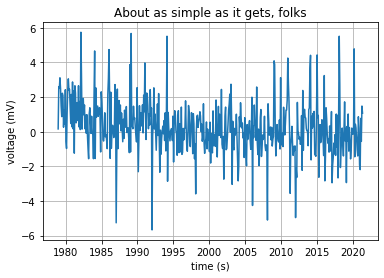

In [82]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(msu.time, msu.bt_anomaly_ls, color='black')
ax.plot(msu.time, re[:][0][0], color='green')
ax.plot(msu.time, msu.bt_anomaly_ls, color='blue')
ax.plot(msu.time, msu.bt_anomaly_ls, color='red')

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='About as simple as it gets, folks')
ax.grid()

fig.savefig("test.png")
plt.show()

In [10]:
tsk = glob.glob('/fio/srvx7/leo/scratch/TSK/*')
tsk

[]

---